In [1]:
import os
import ast
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import constants
from spatiotemporal_cnn.models import SpatiotemporalCNN

In [2]:
def summarize(path, fname, name):
    model_meta = pd.read_csv(os.path.join(path, fname))
    def replace(x):
        try:
            return ast.literal_eval(x)
        except:
            return x
    for col in ['pretrain_train_losses', 'pretrain_valid_losses', 'pretrain_train_acc', 'pretrain_valid_acc', 'pretrain_grad_norm',
                'train_losses', 'valid_losses', 'train_acc', 'valid_acc', 'grad_norm']:
        try:
            model_meta[col] = model_meta[col].apply(replace)
        except:
            pass

    model_meta['epochs'] = model_meta['train_losses'].apply(len)
    model_meta['final_train_loss'] = model_meta['train_losses'].apply(lambda x: x[-1])
    model_meta['final_grad_norm'] = model_meta['grad_norm'].apply(lambda x: x[-1])
    model_meta = model_meta.assign(approach=name)

    return model_meta

In [3]:
def read_cnn_results(root_dir, exp_dir, subject=None):
    args = exp_dir.split('_')[1:]
    df = summarize(os.path.join(root_dir, exp_dir, f's_{subject}' if subject is not None else ''), 'trial_results.csv', 'eegnet')

    df = df.assign(impute=args[0])
    df = df.assign(F1=int(args[1].split('-')[0]))
    df = df.assign(D=int(args[2].split('-')[0]))
    df = df.assign(F2=int(args[3].split('-')[0]))
    df = df.assign(weight_decay=float(args[4].split('-')[0]))
    df = df.assign(dropout=float(args[5].split('-')[0]))
    
    return df

In [86]:
all_model_df = pd.DataFrame()

root_dir = os.path.join(constants.RESULTS_DIR,
                        'motor_LR', 'spatiotemporal_cnn', 'voxel_space', 'rl', 'no_bandpass', 'max_abs_scale',
                        '4_montages', 'cropped', 'scale_2D', 'regularization_grid_search', 'baseline_ph_viable_vox')

subject = '127'

for d in os.listdir(os.path.join(root_dir, f's_{subject}' if subject is not None else None)):
    try:
        df = read_cnn_results(os.path.join(root_dir, f's_{subject}' if subject is not None else None), d, subject if subject is not None else None)
        all_model_df = all_model_df.append(df, ignore_index=True)
    except OSError as e:
        print(e)
    
train_cols = ['train_accuracy', 'train_precision', 'train_recall', 'train_f1']
valid_cols = ['valid_accuracy', 'valid_precision', 'valid_recall', 'valid_f1']
test_cols = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']

In [87]:
all_model_df.columns

Index(['cv_iter', 'Status', 'epoch_early_stop', 'final_test_accuracy',
       'final_test_auc', 'final_test_f1', 'final_test_loss',
       'final_test_precision', 'final_test_recall', 'final_train_accuracy',
       'final_train_auc', 'final_train_f1', 'final_train_precision',
       'final_train_recall', 'final_valid_accuracy', 'final_valid_auc',
       'final_valid_f1', 'final_valid_precision', 'final_valid_recall',
       'grad_norm', 'montage', 'subject', 'test_accuracy', 'test_auc',
       'test_f1', 'test_precision', 'test_recall', 'train_acc',
       'train_accuracy', 'train_auc', 'train_f1', 'train_losses',
       'train_precision', 'train_recall', 'valid_acc', 'valid_accuracy',
       'valid_auc', 'valid_f1', 'valid_losses', 'valid_precision',
       'valid_recall', 'epochs', 'final_train_loss', 'final_grad_norm',
       'approach', 'impute', 'F1', 'D', 'F2', 'weight_decay', 'dropout'],
      dtype='object')

In [88]:
montage_order = ['A', 'B', 'C', 'D']

In [89]:
sorted(all_model_df.weight_decay.unique())

[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

In [90]:
sorted(all_model_df.dropout.unique())

[0.5, 0.6, 0.7, 0.8]

In [91]:
all_model_df.F1.unique()

array([6])

In [92]:
all_model_df.D.unique()

array([12])

Display best hyperparameter settings for each montage

In [93]:
grouped_df = all_model_df.groupby(['montage', 'F1', 'D', 'F2', 'weight_decay', 'dropout']).mean()[test_cols]
best_acc_idx = grouped_df.reset_index().groupby('montage').idxmax()['test_accuracy']
grouped_df.reset_index().loc[best_acc_idx, :].reset_index(drop=True).round(5)

,montage,F1,D,F2,weight_decay,dropout,test_accuracy,test_precision,test_recall,test_f1
0,A,6,12,12,0.0100,0.6,0.65238,0.61593,0.80952,0.69800
1,B,6,12,12,0.0050,0.8,0.63182,0.65241,0.57273,0.60580
2,C,6,12,12,0.0005,0.7,0.59500,0.58934,0.62000,0.60318
3,D,6,12,12,0.5000,0.8,0.67111,0.69470,0.65217,0.67006


Display best hyperparameter settings across all montages

In [94]:
grouped_df = all_model_df.groupby(['F1', 'D', 'F2', 'weight_decay', 'dropout']).mean()[test_cols]
best_acc_idx = grouped_df.reset_index().idxmax()['test_accuracy']
grouped_df.reset_index().loc[best_acc_idx, :].round(5)

F1                 6.00000
D                 12.00000
F2                12.00000
weight_decay       0.00100
dropout            0.50000
test_accuracy      0.61002
test_precision     0.60838
test_recall        0.64338
test_f1            0.61857
Name: 8, dtype: float64

### Analyze montage-specific performance

In [115]:
montage = 'A'

F1 = 6
D = 12
F2 = 12
weight_decay = 0.001
dropout = 0.6

### Test performance metrics (barplot)

In [116]:
melt_test = pd.melt(all_model_df,
                    id_vars = ['F1', 'D', 'F2', 'weight_decay', 'dropout', 'montage'],
                    value_vars = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1'],
                    var_name = 'metric')
melt_test.loc[:, 'metric'] = melt_test.loc[:, 'metric'].apply(lambda x: x.split('_')[1].capitalize())

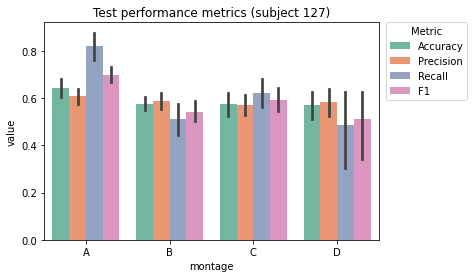

In [117]:
fig, ax = plt.subplots(1, 1)

sns.barplot(data=melt_test[(melt_test['F1'] == F1) &
                           (melt_test['D'] == D) & 
                           (melt_test['F2'] == F2) &
                           (melt_test['weight_decay'] == weight_decay) &
                           (melt_test['dropout'] == dropout)],
            x='montage', y='value', hue='metric', palette='Set2', ax=ax, order=montage_order)
plt.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title(f'Test performance metrics (subject {subject})');

In [118]:
output_df = all_model_df[(all_model_df['F1'] == F1) &
                         (all_model_df['D'] == D) & 
                         (all_model_df['F2'] == F2) &
                         (all_model_df['weight_decay'] == weight_decay) &
                         (all_model_df['dropout'] == dropout)].groupby('montage').mean()
output_df[test_cols + valid_cols + train_cols + ['epochs']].round(3)

,test_accuracy,test_precision,test_recall,test_f1,valid_accuracy,valid_precision,valid_recall,valid_f1,train_accuracy,train_precision,train_recall,train_f1,epochs
montage,,,,,,,,,,,,,
A,0.643,0.608,0.819,0.696,0.657,0.660,0.642,0.645,0.769,0.756,0.784,0.769,300
B,0.573,0.586,0.509,0.541,0.651,0.648,0.683,0.659,0.840,0.841,0.843,0.842,300
C,0.575,0.569,0.620,0.593,0.711,0.684,0.765,0.722,0.854,0.841,0.867,0.854,300
D,0.569,0.581,0.487,0.512,0.576,0.629,0.505,0.529,0.718,0.729,0.745,0.735,300


In [119]:
output_df[test_cols + valid_cols + train_cols + ['epochs']].mean().round(3)

test_accuracy        0.590
test_precision       0.586
test_recall          0.609
test_f1              0.585
valid_accuracy       0.649
valid_precision      0.656
valid_recall         0.649
valid_f1             0.639
train_accuracy       0.795
train_precision      0.792
train_recall         0.810
train_f1             0.800
epochs             300.000
dtype: float64

### Early stopping (validation loss) test accuracy

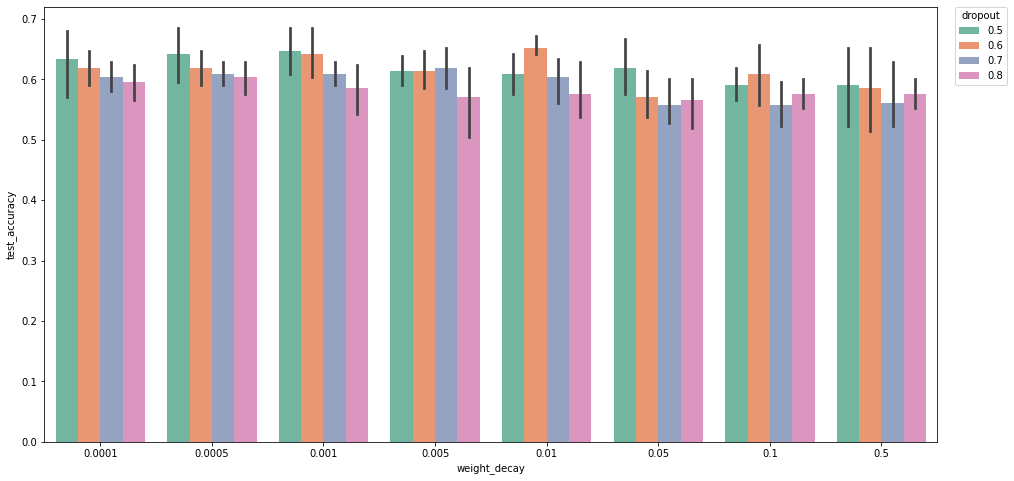

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=all_model_df[(all_model_df['montage'] == montage) &
                              (all_model_df['F1'] == F1) & 
                              (all_model_df['D'] == D) &
                              (all_model_df['F2'] == F2)],
            x='weight_decay', y='test_accuracy', hue='dropout', palette='Set2', ax=ax, order=sorted(all_model_df.weight_decay.unique()))
plt.legend(title='dropout', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title(f'');

### Final test accuracy

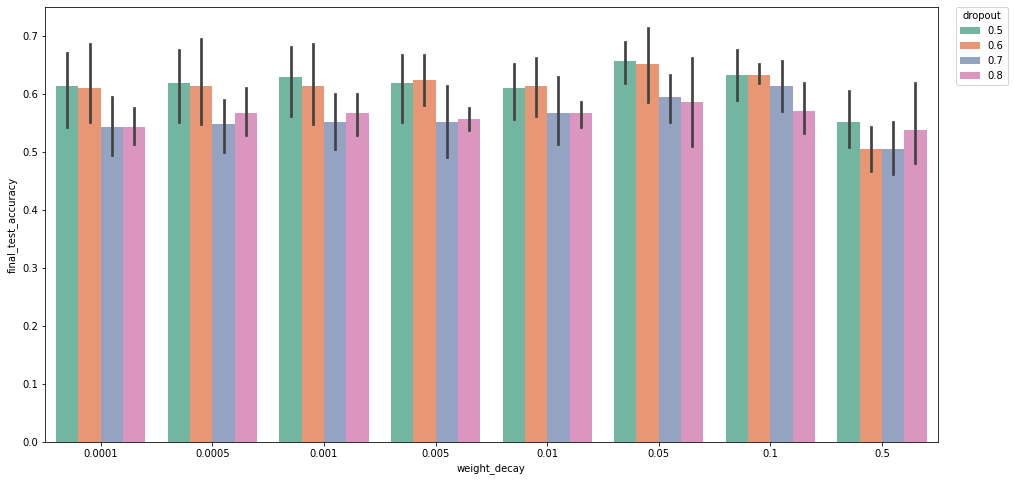

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=all_model_df[(all_model_df['montage'] == montage) &
                              (all_model_df['F1'] == F1) & 
                              (all_model_df['D'] == D) &
                              (all_model_df['F2'] == F2)],
            x='weight_decay', y='final_test_accuracy', hue='dropout', palette='Set2', ax=ax, order=sorted(all_model_df.weight_decay.unique()))
plt.legend(title='dropout', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title(f'');

### Early stopping (validation loss) train accuracy

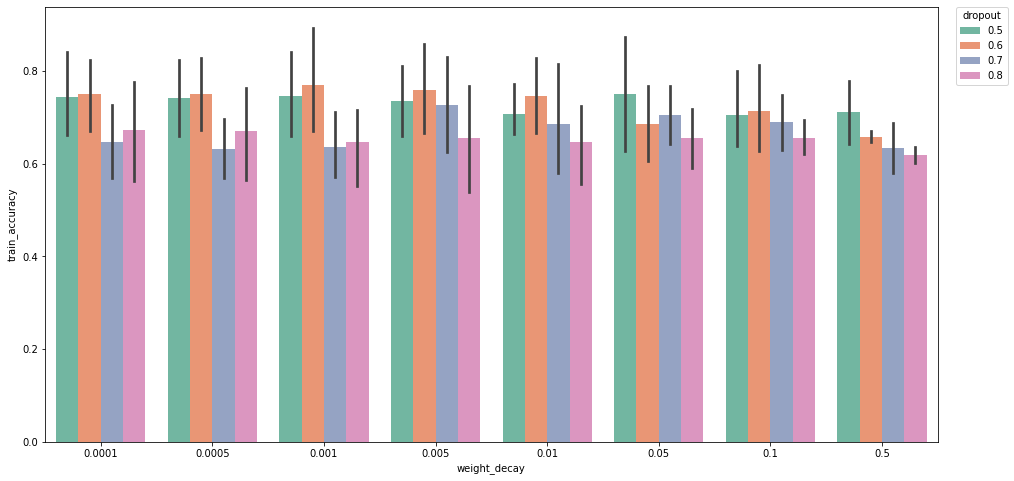

In [122]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=all_model_df[(all_model_df['montage'] == montage) &
                              (all_model_df['F1'] == F1) & 
                              (all_model_df['D'] == D) &
                              (all_model_df['F2'] == F2)],
            x='weight_decay', y='train_accuracy', hue='dropout', palette='Set2', ax=ax, order=sorted(all_model_df.weight_decay.unique()))
plt.legend(title='dropout', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title(f'');

### Final train accuracy

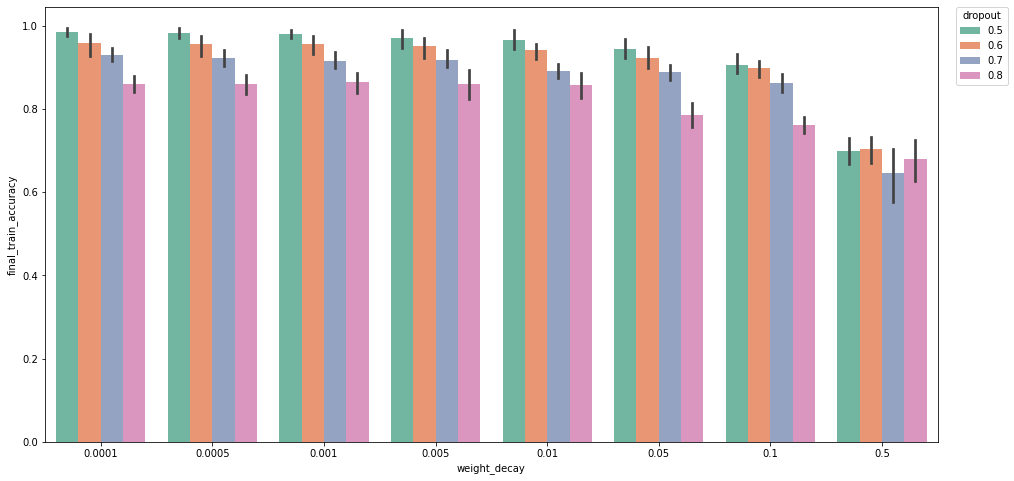

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=all_model_df[(all_model_df['montage'] == montage) &
                              (all_model_df['F1'] == F1) & 
                              (all_model_df['D'] == D) &
                              (all_model_df['F2'] == F2)],
            x='weight_decay', y='final_train_accuracy', hue='dropout', palette='Set2', ax=ax, order=sorted(all_model_df.weight_decay.unique()))
plt.legend(title='dropout', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title(f'');

## Train/Valid Losses

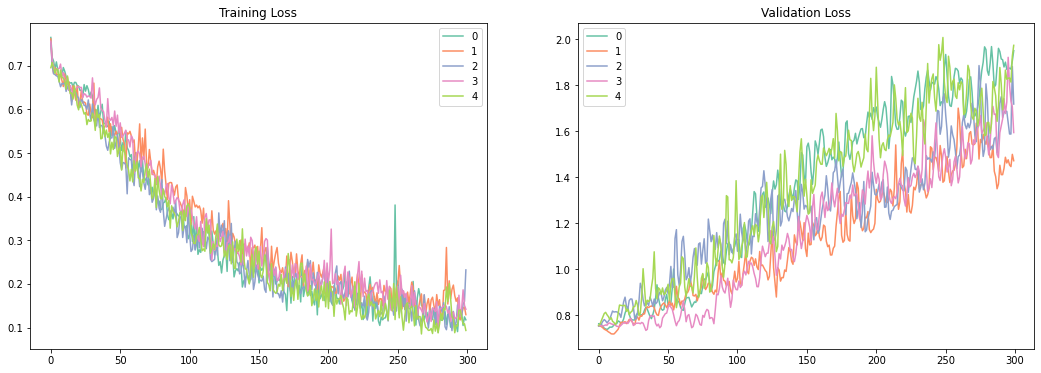

In [124]:
# weight_decay = 0.05
# dropout = 0.8

# F1 = 12
# D = 12
# F2 = 12
# montage = 'C'

subset_df = all_model_df[(all_model_df['F1'] == F1) &
                         (all_model_df['D'] == D) & 
                         (all_model_df['F2'] == F2) & 
                         (all_model_df['weight_decay'] == weight_decay) &
                         (all_model_df['dropout'] == dropout) &
                         (all_model_df['montage'] == montage)]

n = len(subset_df)
colors = plt.cm.Set2(np.linspace(0, 1, 8))

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
for i, idx in enumerate(subset_df.index):
    ax[0].plot(subset_df.loc[idx, 'train_losses'], color=colors[i])
    ax[1].plot(subset_df.loc[idx, 'valid_losses'], color=colors[i])
    ax[0].set_title('Training Loss')
    ax[1].set_title('Validation Loss')
    if subject is not None:
        ax[0].legend(subset_df.cv_iter.unique())
        ax[1].legend(subset_df.cv_iter.unique())
    else:
        ax[0].legend(subset_df.subject.unique())
        ax[1].legend(subset_df.subject.unique())

## Train/Valid Accuracies

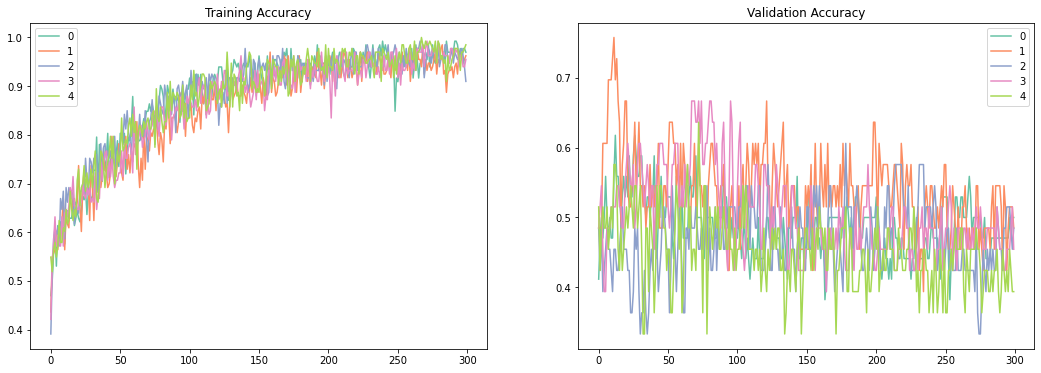

In [125]:
subset_df = all_model_df[(all_model_df['F1'] == F1) &
                         (all_model_df['D'] == D) & 
                         (all_model_df['F2'] == F2) &
                         (all_model_df['weight_decay'] == weight_decay) &
                         (all_model_df['dropout'] == dropout) &
                         (all_model_df['montage'] == montage)]

n = len(subset_df)
colors = plt.cm.Set2(np.linspace(0, 1, 8))

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
for i, idx in enumerate(subset_df.index):
    ax[0].plot(subset_df.loc[idx, 'train_acc'], color=colors[i])
    ax[1].plot(subset_df.loc[idx, 'valid_acc'], color=colors[i])
    ax[0].set_title('Training Accuracy')
    ax[1].set_title('Validation Accuracy')
    if subject is not None:
        ax[0].legend(subset_df.cv_iter.unique())
        ax[1].legend(subset_df.cv_iter.unique())
    else:
        ax[0].legend(subset_df.subject.unique())
        ax[1].legend(subset_df.subject.unique())

## Gradient Norm

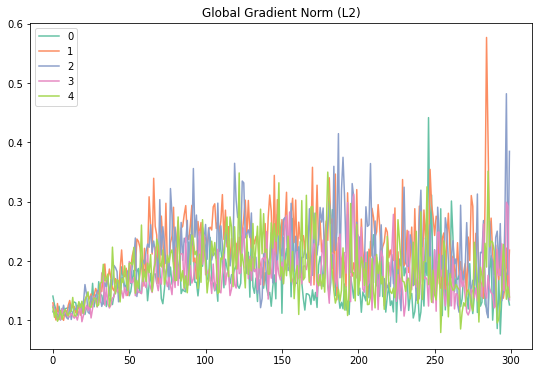

In [126]:
subset_df = all_model_df[(all_model_df['F1'] == F1) &
                         (all_model_df['D'] == D) & 
                         (all_model_df['F2'] == F2) & 
                         (all_model_df['weight_decay'] == weight_decay) &
                         (all_model_df['dropout'] == dropout) &
                         (all_model_df['montage'] == montage)]

n = len(subset_df)
colors = plt.cm.Set2(np.linspace(0, 1, 8))

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
for i, idx in enumerate(subset_df.index):
    ax.plot(subset_df.loc[idx, 'grad_norm'], color=colors[i])
    ax.set_title('Global Gradient Norm (L2)')
    if subject is not None:
        ax.legend(subset_df.cv_iter.unique())
    else:
        ax.legend(subset_df.subject.unique())

## View predictions

In [127]:
# montage = 'A'
phase = 'test'
final = False
cv_iter = 0

exp_dir = f'eegnet_zero_{F1}-F1_{D}-D_{F2}-F2_{weight_decay}-L2_{dropout}-p'

def aggregate_predictions(root_dir, exp_dir, subject, montage, phase):
    
    out_df = pd.DataFrame()
    for i in range(5):
        df = pd.read_parquet(
            os.path.join(root_dir,
                         f's_{subject}' if subject is not None else '',
                         exp_dir,
                         f's_{subject}' if subject is not None else '',
                         'final_predictions' if final else 'predictions',
                         f'{subject}_{montage}_{phase}_{i}.parquet'))
        out_df = out_df.append(df, ignore_index=True)
        
    return out_df

pred_df = aggregate_predictions(root_dir, exp_dir, subject, montage, phase)
pred_df['pred'] = pred_df['pred'].astype(np.float32)
subset_df = pred_df[pred_df['cv_iter'] == cv_iter]
subset_df

,subject_id,montage,cv_iter,true,pred,prob
0,127,A,0,1.0,1.0,0.546952
1,127,A,0,1.0,1.0,0.627603
2,127,A,0,1.0,1.0,0.653185
3,127,A,0,0.0,1.0,0.512996
4,127,A,0,0.0,0.0,0.492343
5,127,A,0,0.0,1.0,0.523121
6,127,A,0,0.0,0.0,0.352833
7,127,A,0,1.0,1.0,0.556804
8,127,A,0,0.0,1.0,0.575262
9,127,A,0,0.0,0.0,0.462197


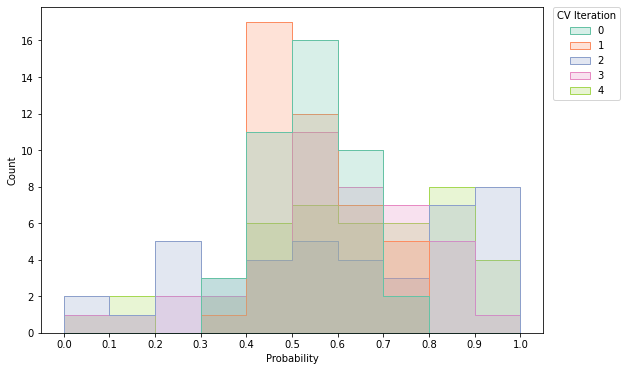

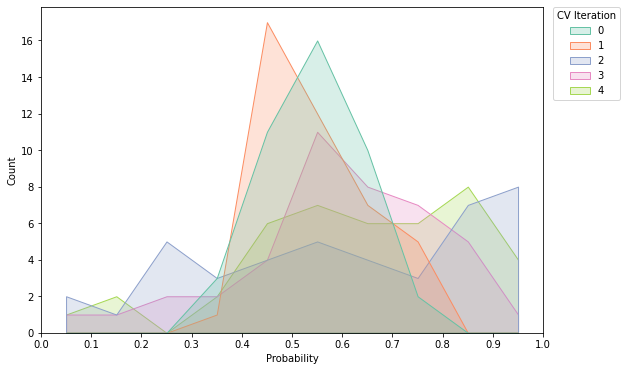

In [128]:
def move_legend(ax, new_title, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    if new_title is not None:
        title = new_title
    else:
        title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

g = sns.histplot(data=pred_df, x='prob', hue='cv_iter', element='step', fill=True, binwidth=0.1, binrange=(0, 1),
                 palette='Set2', ax=ax)
g.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
move_legend(ax, new_title='CV Iteration', bbox_to_anchor=(1.02, 1), new_loc=2, borderaxespad=0.)
ax.set_xlabel('Probability');

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

g = sns.histplot(data=pred_df, x='prob', hue='cv_iter', element='poly', fill=True, binwidth=0.1, binrange=(0, 1),
                 palette='Set2', ax=ax)
g.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
move_legend(ax, new_title='CV Iteration', bbox_to_anchor=(1.02, 1), new_loc=2, borderaxespad=0.)
ax.set_xlabel('Probability');

In [129]:
from sklearn.metrics import accuracy_score

accuracy_score(subset_df['true'], subset_df['pred'])

0.5952380952380952

In [130]:
np.bincount(subset_df.true.values.astype(int))

array([21, 21])

In [131]:
subset_df.pred.unique()

array([1., 0.], dtype=float32)